In [1]:
import numpy as np
import scipy as sp
import pandas as pd # load data
import matplotlib.pyplot as plt # plotting
from iminuit import Minuit
from scipy import stats
from scipy.stats import norm

In [2]:
import os, sys 
sys.path.append('/Users/siljaxianpallisgaardsvendsen/Documents/KU_K/8_AppStat/AppStat2023')
from ExternalFunctionsNew import Chi2Regression, BinnedLH, UnbinnedLH

In [3]:
from Module_241021 import (load_data_w_glob,
                           plot_distributions_at_diff_scale_factors
                          )

In [4]:
# load time diff data
diff_tau_all = pd.read_csv("time_delay_diff_241021.csv")

# load + pickout velocity data
PSA_all_df = load_data_w_glob(directory_path="PSA_data", file_pattern="*241021.csv")
velocity_all = PSA_all_df[["network", "parameter", "rel change", "condition 1", "condition 2", "velocity"]]

## A closer look at delay time differences between the GN and GNE networks

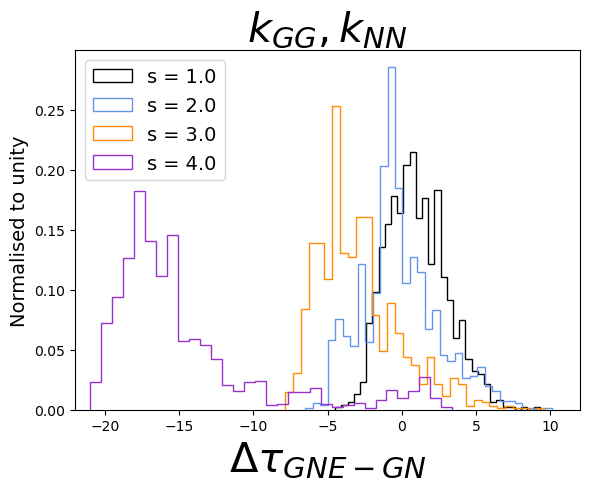

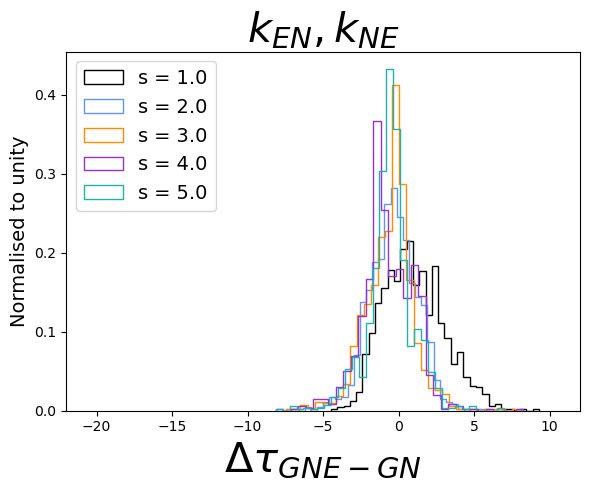

In [5]:
plot_distributions_at_diff_scale_factors(dataframe=diff_tau_all,network="GNEvGN", parameter="KaaNG",
                                         scalefactor_array=[2.0, 3.0, 4.0],
                                         title=r"$k_{GG}, k_{NN}$", x_label=r"$\Delta\tau_{GNE-GN}$",
                                         xmin=-22, xmax=12,
                                         date="241105", datatype="time diff",
                                         legend_loc="upper left",savefig=False)
plot_distributions_at_diff_scale_factors(dataframe=diff_tau_all,network="GNEvGN", parameter="KmiEN",
                                         scalefactor_array=[2.0, 3.0, 4.0, 5.0],
                                         title=r"$k_{EN}, k_{NE}$", x_label=r"$\Delta\tau_{GNE-GN}$",
                                         xmin=-22, xmax=12,
                                         date="241105",
                                         datatype="time diff",legend_loc="upper left",
                                         savefig=False)

### Fit distributions to a double gaussian (bi-modality) and a skewed distribution (single peak).

Motivation:
In Knudsen et al, bi-modility is observed for time delay differences. I want to investigate if the case applies here too. This is done by fitting the distributions to a double-gaussian and a model with only one peak.

If bi-modal, does the negative delay time differences arise from higher occurances of negative delay time differences (higher peak) or does the delay time differences become more negative (broader distance between peaks)?

**Fit functions:** <br>

Skewed Gaussian

Skewed Double Gaussian

In [58]:
# select data
dataframe=diff_tau_all
network="GNEvGN"
parameter="KaaNG"
scalefactor=4.0
data_color="darkorchid"#"cornflowerblue"#"darkorange"
font_size=40

mask0 = dataframe["two_networks"]==network
mask1 = dataframe["parameter"]==parameter
mask2 = dataframe["rel change"]==scalefactor

sample = dataframe[mask0 & mask1 & mask2]["time diff"]

Nbins = int(np.sqrt(len(sample)))
binwidth_gauss = (max(sample)-min(sample))/float(Nbins)
print("bindwidth", binwidth_gauss)

bindwidth 0.7386248661429322


In [59]:
def nice_string_text(x,y, minuit_obj, entries, fit_color, fitfunc, font_size_text=12, ax=None):
    '''
    x, y: figure position of string (left lower corner)
    fitfunc: "string"
    '''

    #fit information dictionary
    chi2_obj_value = minuit_obj.fval 
    Ndof_obj_value = len(X[select]) - minuit_obj.nfit
    Prob_obj_value = stats.chi2.sf(chi2_obj_value, Ndof_obj_value) # The chi2 probability given N_DOF degrees of freedom
    print(Prob_obj_value)
    fit_info = (
        f"Entries: {entries}\n"
        f"Chi2/ Ndof: {chi2_obj_value:.2f}/ {Ndof_obj_value}\n"
        f"Prob(Chi2, Ndof): {Prob_obj_value:.2f}")
        
        


    # fit parameter dictionary
    params_dict = {param: (minuit_obj.values[param], minuit_obj.errors[param])
                   for param in minuit_obj.parameters}

    # Format it into a multi-line string
    fit_params = "\n".join(fr"{key} = {value:.1f} $\pm$ {error:.1f}"
                               for key, (value, error) in params_dict.items())

    # join text
    formatted_text = fitfunc+":\n" + fit_info + "\n" + fit_params


    # Plot and display the text on the figure
    if ax==None:
        fig, ax=plt.subplots(figsize=(5,5))
    else:
        ax=ax
        ax.text(x, y, formatted_text, fontsize=font_size_text, transform=plt.gca().transAxes, color=fit_color)

def fit_skewed_gaussian(x, N, mu, sigma, alpha):
    '''
    skewed gaussian
    (N*bandwidth)/(sigma*sqrt(2*pi)) * exp(-0.5*((x-mu)/sigma)**2) * norm.cdf(alpha * (x-mu)/sigma)
    '''
    Norm = binwidth_gauss * N/ np.sqrt(2.0*np.pi) / sigma
    z = (x-mu)/sigma
    phi = Norm*np.exp(-0.5 * z**2)
    Phi = norm.cdf(alpha * (x - mu) / sigma)
    return 2 * phi * Phi


def fit_skewed_double_gaussian(x, N1, mu1, sigma1, alpha1, N2, mu2, sigma2, alpha2):
    '''
    skewed double gaussian
    '''
    skewed_gaussian1 = fit_skewed_gaussian(x, N1, mu1, sigma1, alpha1)
    skewed_gaussian2 = fit_skewed_gaussian(x, N2, mu2, sigma2, alpha2)
    return skewed_gaussian1 + skewed_gaussian2

1.2194171438068186e-19
1.3377567532224434e-08


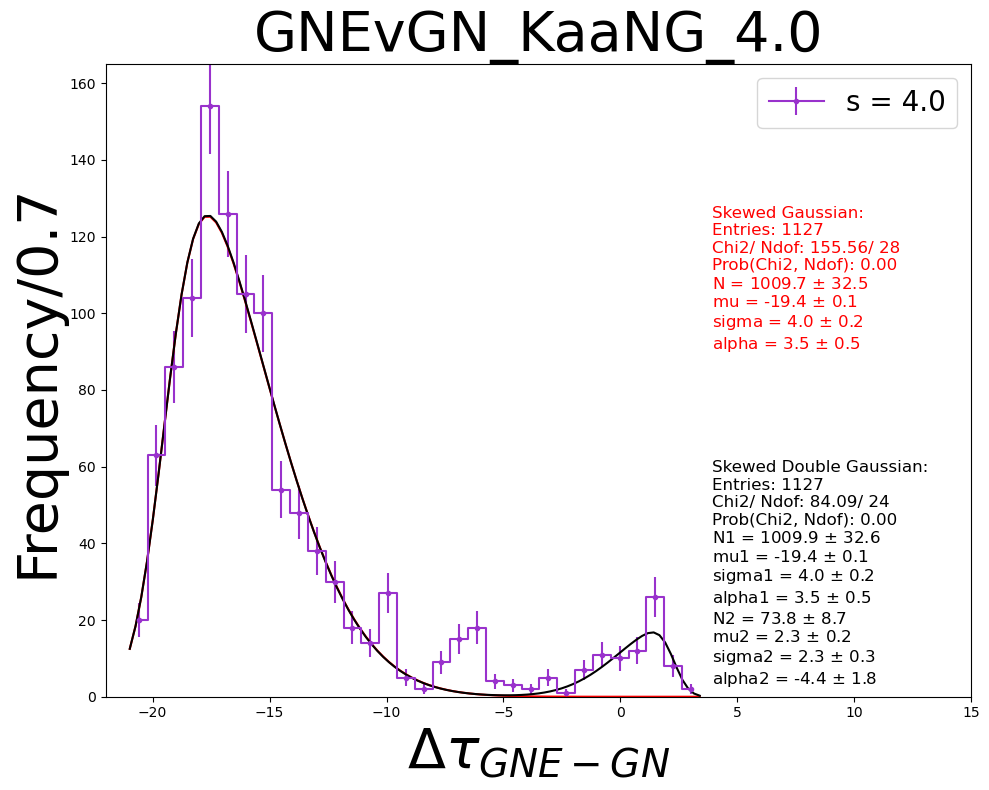

In [73]:
#0.0 prepare data for fitting
binning = np.linspace(min(sample), max(sample), Nbins)
counts, bin_edges = np.histogram(sample, bins=binning)
unc_counts = np.sqrt(counts)
X = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2
select = counts>0

# 0.1 plot data as aid to set initial guesses
fig, ax = plt.subplots(figsize = (10, 8))
ax.errorbar(X, counts, yerr=unc_counts,
            marker=".", drawstyle="steps-mid", color=data_color,
            label=f"s = {scalefactor}"
           )
# 0.2 add labels etc.
ax.set_title(f"{network}_{parameter}_{scalefactor}", fontsize=font_size)
ax.set_xlabel(r"$\Delta\tau_{GNE-GN}$", fontsize=font_size)
ax.set_ylabel(f"Frequency/{np.around(binwidth_gauss,1)}", fontsize=font_size)
plt.legend(fontsize=20, loc="upper right")

#1.1 chi2 fiting: one peak
chi2reg_sg=Chi2Regression(fit_skewed_gaussian, X[select], counts[select], unc_counts[select])
minuit_obj_sg=Minuit(chi2reg_sg,
                     N = 140, mu=-17.0, sigma=4, alpha=2
                    )
minuit_obj_sg.errordef = 1.0 #chi2 fit
minuit_obj_sg.migrad() # run minimisation

#1.2 chi2 fiting: two
chi2reg_sgg=Chi2Regression(fit_skewed_double_gaussian, X[select], counts[select], unc_counts[select])
minuit_obj_sgg=Minuit(chi2reg_sgg,
                      N1 = 140, mu1=-17, sigma1=4, alpha1=4,
                      N2 = 20, mu2=1, sigma2=4, alpha2=-4,
                     )
minuit_obj_sgg.errordef = 1.0
minuit_obj_sgg.migrad() # run minimisation

# 2.1 plot fits
x = np.linspace(min(sample), max(sample), 100)
ax.plot(x, fit_skewed_gaussian(x, *minuit_obj_sg.values[:]),
        color="red", label="Skewed Gaussian")
ax.plot(x, fit_skewed_double_gaussian(x, *minuit_obj_sgg.values[:]),
        color="black", label="Skewed Double Gaussian")


nice_string_text(x=0.7, y=0.55, minuit_obj=minuit_obj_sg, entries=len(sample),
                 fit_color="red", fitfunc="Skewed Gaussian",font_size_text=12, ax=ax)
nice_string_text(x=0.7, y=0.02, minuit_obj=minuit_obj_sgg, entries=len(sample),
                 fit_color="black", fitfunc="Skewed Double Gaussian",font_size_text=12,ax=ax)
# figure adjustments
ax.set_xlim(-22,15)
ax.set_ylim(0,165)
plt.tight_layout()
plt.savefig(f"{network}_{parameter}_{scalefactor}.pdf", dpi=600)

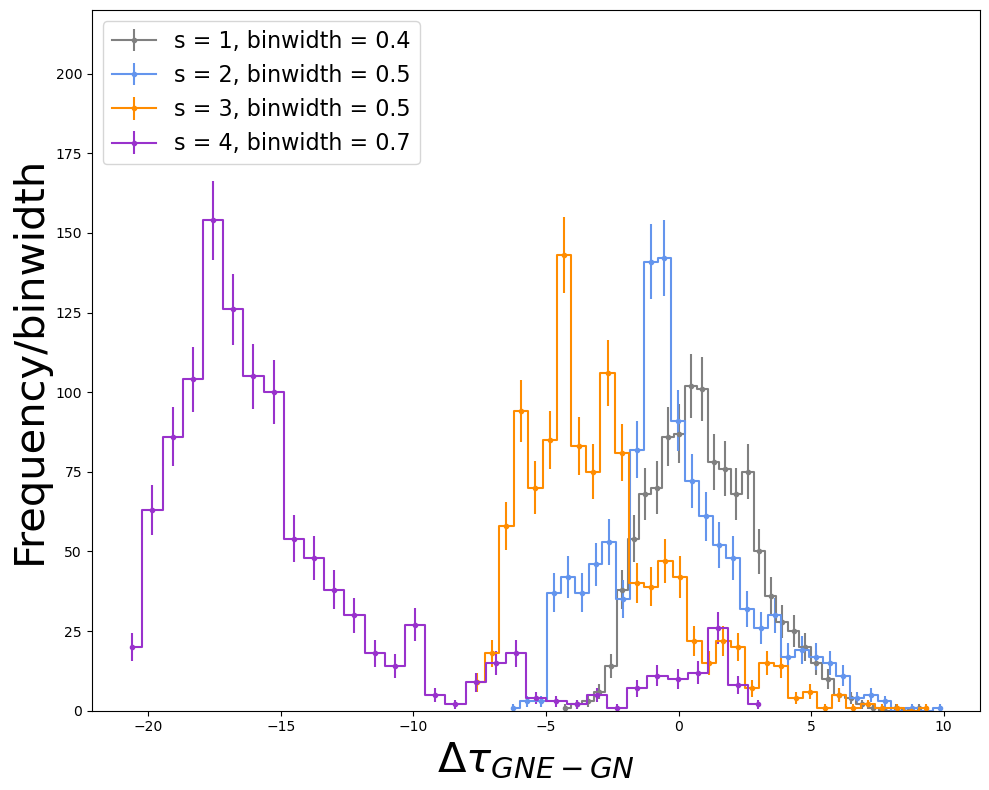

In [9]:
fig, ax = plt.subplots(figsize=(10,8))

for scalefactor, data_color in zip([1, 2, 3, 4],
                                   ["gray", "cornflowerblue", "darkorange", "darkorchid"]):

    # select data
    dataframe=diff_tau_all
    network="GNEvGN"
    parameter="KaaNG"
    font_size=30

    mask0 = dataframe["two_networks"]==network
    mask1 = dataframe["parameter"]==parameter
    mask2 = dataframe["rel change"]==scalefactor

    sample = dataframe[mask0 & mask1 & mask2]["time diff"]

    Nbins = int(np.sqrt(len(sample)))
    binwidth_gauss = (max(sample)-min(sample))/float(Nbins)
    
    #0.0 prepare data for fitting
    binning = np.linspace(min(sample), max(sample), Nbins)
    counts, bin_edges = np.histogram(sample, bins=binning)
    unc_counts = np.sqrt(counts)
    X = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2
    select = counts>0
    
    
    
    ax.errorbar(X, counts, yerr=unc_counts,
            marker=".", drawstyle="steps-mid", color=data_color,
            label=f"s = {scalefactor}, binwidth = {binwidth_gauss:.1f}"
           )
# 0.2 add labels etc.
ax.set_xlabel(r"$\Delta\tau_{GNE-GN}$", fontsize=font_size)
ax.set_ylabel(f"Frequency/binwidth", fontsize=font_size)
plt.legend(fontsize=16, loc="upper left")
ax.set_ylim(0,220)
plt.tight_layout()
plt.savefig(f"{network}_{parameter}.pdf",dpi=600)
    
    